## Mud card
- **Does gridsearchcv work for xgoost, or do we have a similar option to use?**
   - yes, it does. XGBoost is compatible with sklearn so you can use it the same as any other sklearn supervised ML method
- **Can we go over the missing patterns detection one more time**
   - sure

In [1]:
# read the data
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split

# Let's load the data
df = pd.read_csv('data/train.csv')
# drop the ID
df.drop(columns=['Id'],inplace=True)

# the target variable
y = df['SalePrice']
df.drop(columns=['SalePrice'],inplace=True)
# the unprocessed feature matrix
X = df.values
print(X.shape)
# the feature names
ftrs = df.columns

(1460, 79)


In [2]:
# let's split to train, CV, and test
X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_CV.shape)
print(X_test.shape)

(876, 79)
(292, 79)
(292, 79)


In [3]:
# collect the various features
cat_ftrs = ['MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1','Condition2',\
            'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',\
           'Heating','CentralAir','Electrical','GarageType','PavedDrive','MiscFeature','SaleType','SaleCondition']
ordinal_ftrs = ['LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',\
               'BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish',\
               'GarageQual','GarageCond','PoolQC','Fence']
ordinal_cats = [['Reg','IR1','IR2','IR3'],['AllPub','NoSewr','NoSeWa','ELO'],['Gtl','Mod','Sev'],\
               ['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Po','Fa','TA','Gd','Ex'],['NA','No','Mn','Av','Gd'],['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],\
               ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],\
               ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Unf','RFn','Fin'],['NA','Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],
               ['NA','Fa','TA','Gd','Ex'],['NA','MnWw','GdWo','MnPrv','GdPrv']]
num_ftrs = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd',\
             'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',\
             'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
             'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
             'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

In [4]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [5]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.transformers_[0][-1] + \
                list(preprocessor.named_transformers_['cat'][1].get_feature_names(cat_ftrs)) + \
                preprocessor.transformers_[2][-1]

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(df_train.shape)

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(df_CV.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_test.shape)

(876, 221)
(292, 221)
(292, 221)


In [18]:
mask = df_test[['LotFrontage','MasVnrArea','GarageYrBlt']].isnull()
#print(mask[:10])
unique_rows, counts = np.unique(mask, axis=0,return_counts=True)
for i in range(len(counts)):
    print(unique_rows[i],counts[i])
mask_train = df_train[['LotFrontage','MasVnrArea','GarageYrBlt']].isnull()
print(mask_train[10:20])

[False False False] 223
[False False  True] 21
[False  True False] 1
[ True False False] 44
[ True False  True] 2
[ True  True False] 1
    LotFrontage  MasVnrArea  GarageYrBlt
10        False       False        False
11        False       False        False
12        False       False        False
13         True       False         True
14        False       False        False
15        False       False        False
16        False       False        False
17        False       False        False
18        False       False        False
19         True       False        False


## Overview of methods to deal with missing data
- **drop points**
   - it's OK for MCAR and small amount of missing values
- **mean or median imputation** 
   - avoid

- **multivariate imputation** 
   - it's OK if it make sense to impute feature values (not always the case)
   - it's OK for MCAR and MAR
- **XGBoost**
   - no imputation, works with nans in the feature matrix
   - best choice if tree-based methods (step predictions) are acceptable to you
- **reduced features model**
   - no imputation, uses a complete subset of features and points for each pattern
   - model-agnostic

## Global feature importance metrics
By the end of this lecture, you will be able to
 - perform permutation feature importance calculation
 - study the coefficients of linear models
 - outlook to other metrics 

## Motivation
 - debugging ML models is tough
    - a model that runs without errors/warning is not necessarily correct
 - how do you know that you model is correct?
    - check test set predictions
       - in regression: check points with a large difference between true and predicted values
       - in classification: confusion matrix, check out FPs and FNs
    - inspect your model
       - especially useful for non-linear models
       - metrics to measure how much a model depends on a feature is one way to inspect your model

## <font color='LIGHTGRAY'>Global feature importance metrics</font>
<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
 - **perform permutation feature importance calculation**
 - <font color='LIGHTGRAY'>study coefficients ($\beta$ parameters) of linear models</font>
 - <font color='LIGHTGRAY'>outlook to other metrics </font>

## Permutation feature importance
 - model agnostic, you can use it with any supervised ML model
 - steps:
    - train a model and calculate a test score :)
    - randomly shuffle a single feature in the test set
    - recalculate the test score with the shuffled data
    - model score worsens because the shuffling breaks the relationship between feature and target
    - the larger the difference, the more important the feature is

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt

df = pd.read_csv('data/adult_data.csv')
label = 'gross-income'
y = LabelEncoder().fit_transform(df[label])
df.drop(columns=[label],inplace=True)
X = df
ftr_names = X.columns
print(X.head())
print(y)

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0          2174             0              40   United-States  
1           

In [8]:
def ML_pipeline_kfold(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    pipe = make_pipeline(preprocessor,SVC())
    # the parameter(s) we want to tune
    param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100],
                  'svc__gamma': [0.01, 0.1, 1, 10, 100]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1,verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    return grid, X_test, y_test

## Do not run this on the hub :)

In [ ]:
grid, X_test, y_test = ML_pipeline_kfold(X,y,42,4)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

# save the output so I can use it later
import pickle
file = open('results/grid.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

In [9]:
import pickle
file = open('results/grid.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 0)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.8624289881774911
test baseline =  0.7587901120835252
shuffling age
   shuffled test score: 0.851 +/- 0.001
shuffling workclass
   shuffled test score: 0.86 +/- 0.001
shuffling fnlwgt
   shuffled test score: 0.861 +/- 0.001
shuffling education
   shuffled test score: 0.861 +/- 0.001
shuffling education-num
   shuffled test score: 0.841 +/- 0.001
shuffling marital-status
   shuffled test score: 0.841 +/- 0.002
shuffling occupation
   shuffled test score: 0.845 +/- 0.002
shuffling relationship
   shuffled test score: 0.851 +/- 0.001
shuffling race
   shuffled test score: 0.862 +/- 0.001
shuffling sex
   shuffled test score: 0.862 +/- 0.001
shuffling capital-gain
   shuffled test score: 0.823 +/- 0.002
shuffling capital-loss
   shuffled test score: 0.855 +/- 0.001
shuffling hours-per-week
   shuffled test score: 0.856 +/- 0.002
shuffling native-country
   shuffled test score: 0.861 +/- 0.0


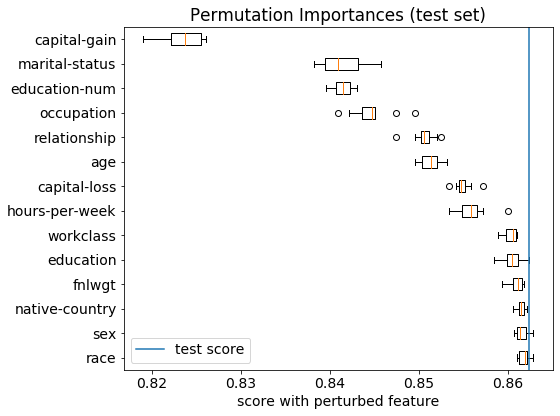

In [15]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

## Cons of permutation feature importance
- strongly correlated features
   - if one of the features is shuffled, the model can still use the other correlated feature
   - both features appear to be less important but they might actually be important
   - solution:
      - check the correlation matrix plot
      - remove all but one of the strongly correlated features
- no feature interactions
   - one feature might appear unimportant but combined with another feature could be important
   - solution:
      - permute two features to measure how important feature pairs are
      - this can be computationally expensive

## <font color='LIGHTGRAY'>Global feature importance metrics</font>
<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
 - <font color='LIGHTGRAY'>perform permutation feature importance calculation</font>
 - **study the coefficients of linear models**
 - <font color='LIGHTGRAY'>outlook to other metrics </font>

## Coefficients of linear models
- the coefficients of linear and logistic regression can be used as a measure of feature importance **ONLY IF** all features have a zero mean and the same standard deviation (usually 1)
   - all features meaning that the one-hot encoded and ordinal features as well!
- then the absolute value of the coefficients can be used to rank them

## Let's rewrite the kfold CV function a bit

In [20]:
from sklearn.linear_model import LogisticRegression
def ML_pipeline_kfold_LR1(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    pipe = make_pipeline(preprocessor,LogisticRegression(penalty='l2',solver='lbfgs'))
    # the parameter(s) we want to tune
    param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10,100]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = cont_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, np.array(feature_names), X_test, y_test

/anaconda3/envs/datasci_v0.0.2_local4.yml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


test score: 0.8581298940580377


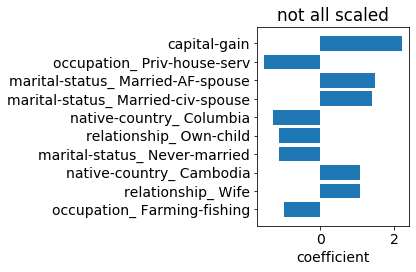

In [12]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold_LR1(X,y,42,4)
print('test score:',grid.score(X_test,y_test))
coefs = grid.best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.rcParams.update({'font.size': 14})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.title('not all scaled')
plt.tight_layout()
plt.savefig('figures/LR_coefs_notscaled.png',dpi=300)
plt.show()

In [22]:
from sklearn.linear_model import LogisticRegression
def ML_pipeline_kfold_LR2(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    final_scaler = StandardScaler()
    pipe = make_pipeline(preprocessor,final_scaler,LogisticRegression(penalty='l2',solver='lbfgs'))
    # the parameter(s) we want to tune
    param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10,100]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1,verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = cont_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, np.array(feature_names), X_test, y_test

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    4.5s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:    4.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:    5.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.5s finished


test score: 0.857976354982343


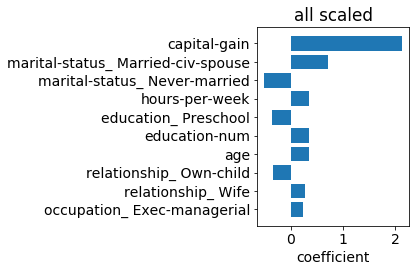

In [23]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold_LR2(X,y,42,4)
print('test score:',grid.score(X_test,y_test))
coefs = grid.best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.rcParams.update({'font.size': 14})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.title('all scaled')
plt.tight_layout()
plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
plt.show()

<table><tr>
<td> <img src="figures/LR_coefs_notscaled.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="figures/LR_coefs_scaled.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

## <font color='LIGHTGRAY'>Global feature importance metrics</font>
<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
 - <font color='LIGHTGRAY'>perform permutation feature importance calculation</font>
 - <font color='LIGHTGRAY'>study the coefficients of linear models</font>
 - **outlook to other metrics**


- SVM:
   - SVC.coef_ and SVR.coef_ can be used as a metric of feature importance if **all** features are standardized
   - for linear SVMs only!
- random forest:
   - RandomForestRegressor.feature_importances_ and RandomForestClassification.feature_importances_
   - gini importance or mean decrease impurity, see [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) and [here](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)
- XGBoost:
   - five different metrics are implemented, see [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score) and [here](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)